## Kaggle: Airbnb New User Bookings

The detailed information and download the data from the following link:<br/>
https://www.kaggle.com/c/airbnb-recruiting-new-user-bookings/data

Goal: predict which country a new user's first booking destination will be. All the users in this dataset are from the USA.

- here are 12 possible outcomes of the destination country: 'US', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL','DE', 'AU', 'NDF' (no destination found), and 'other'. Please note that 'NDF' is different from 'other' because 'other' means there was a booking, but is to a country not included in the list, while 'NDF' means there wasn't a booking.


- The training and test sets are split by dates. In the test set, you will predict all the new users with first activities after 7/1/2014 (note: this is updated on 12/5/15 when the competition restarted). In the sessions dataset, the data only dates back to 1/1/2014, while the users dataset dates back to 2010. 

In [1]:
## Type your answers here ##
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns
import datetime
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

## 1. Load data

In [2]:
train = pd.read_csv('train_users_2.csv')
test = pd.read_csv('test_users.csv')
session = pd.read_csv('sessions.csv')

In [3]:
print(train.shape)
print(test.shape)
print(session.shape)

(213451, 16)
(62096, 15)
(10567737, 6)


## 2. Exploratory Data Analysis

In [4]:
train.head(3)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,gxn3p5htnn,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,820tgsjxq7,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,4ft3gnwmtx,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US


In [5]:
test.head(3)

,id,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser
0,5uwns89zht,2014-07-01,20140701000006,NaN,FEMALE,35.0,facebook,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
1,jtl0dijy2j,2014-07-01,20140701000051,NaN,-unknown-,NaN,basic,0,en,direct,direct,untracked,Moweb,iPhone,Mobile Safari
2,xx0ulgorjt,2014-07-01,20140701000148,NaN,-unknown-,NaN,basic,0,en,direct,direct,linked,Web,Windows Desktop,Chrome


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 213451 entries, 0 to 213450
Data columns (total 16 columns):
id                         213451 non-null object
date_account_created       213451 non-null object
timestamp_first_active     213451 non-null int64
date_first_booking         88908 non-null object
gender                     213451 non-null object
age                        125461 non-null float64
signup_method              213451 non-null object
signup_flow                213451 non-null int64
language                   213451 non-null object
affiliate_channel          213451 non-null object
affiliate_provider         213451 non-null object
first_affiliate_tracked    207386 non-null object
signup_app                 213451 non-null object
first_device_type          213451 non-null object
first_browser              213451 non-null object
country_destination        213451 non-null object
dtypes: float64(1), int64(2), object(13)
memory usage: 26.1+ MB


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62096 entries, 0 to 62095
Data columns (total 15 columns):
id                         62096 non-null object
date_account_created       62096 non-null object
timestamp_first_active     62096 non-null int64
date_first_booking         0 non-null float64
gender                     62096 non-null object
age                        33220 non-null float64
signup_method              62096 non-null object
signup_flow                62096 non-null int64
language                   62096 non-null object
affiliate_channel          62096 non-null object
affiliate_provider         62096 non-null object
first_affiliate_tracked    62076 non-null object
signup_app                 62096 non-null object
first_device_type          62096 non-null object
first_browser              62096 non-null object
dtypes: float64(2), int64(2), object(11)
memory usage: 7.1+ MB


In [8]:
# check the target variable
train.country_destination.unique()

array(['NDF', 'US', 'other', 'FR', 'CA', 'GB', 'ES', 'IT', 'PT', 'NL',
       'DE', 'AU'], dtype=object)

#### 2.1 Merge two datasets

In [9]:
# change date variable format to date
train['date_account_created'] = pd.to_datetime(train['date_account_created'])
test['date_account_created'] = pd.to_datetime(test['date_account_created'])

In [10]:
# check the date users are splitted into train and test datasets
print('Date range in train dataset is:',
      (train.date_account_created.min(),
       train.date_account_created.max()))
print('Date range in test dataset is:',
      (test.date_account_created.min(), test.date_account_created.max()))

Date range in train dataset is: (Timestamp('2010-01-01 00:00:00'), Timestamp('2014-06-30 00:00:00'))
Date range in test dataset is: (Timestamp('2014-07-01 00:00:00'), Timestamp('2014-09-30 00:00:00'))


In [11]:
# check the users in train and test datasets
print('Users in train datasets:', train.shape[0], '\nUsers in test dataset:',test.shape[0])
print('Total users:',train.shape[0]+test.shape[0])

Users in train datasets: 213451 
Users in test dataset: 62096
Total users: 275547


In [12]:
# merge two datasets
users = pd.concat((train,test), axis=0, ignore_index=True)
users = users.drop('id',axis=1)
users.head()

,affiliate_channel,affiliate_provider,age,country_destination,date_account_created,date_first_booking,first_affiliate_tracked,first_browser,first_device_type,gender,language,signup_app,signup_flow,signup_method,timestamp_first_active
0,direct,direct,NaN,NDF,2010-06-28,NaN,untracked,Chrome,Mac Desktop,-unknown-,en,Web,0,facebook,20090319043255
1,seo,google,38.0,NDF,2011-05-25,NaN,untracked,Chrome,Mac Desktop,MALE,en,Web,0,facebook,20090523174809
2,direct,direct,56.0,US,2010-09-28,2010-08-02,untracked,IE,Windows Desktop,FEMALE,en,Web,3,basic,20090609231247
3,direct,direct,42.0,other,2011-12-05,2012-09-08,untracked,Firefox,Mac Desktop,FEMALE,en,Web,0,facebook,20091031060129
4,direct,direct,41.0,US,2010-09-14,2010-02-18,untracked,Chrome,Mac Desktop,-unknown-,en,Web,0,basic,20091208061105


#### 2.2 Deal with missing values

<font size=3> The columns containing NA values:
    * date_first_booking variable contains 'NaN' values
    * gender variable contains 'unkonwn' and 'other' values
    * age variable contrains 'NaN' values
    * first_affiliate_tracked variable contains 'NaN' values

In [13]:
print ('users dataset ({} rows) null value:\n'.format(users.shape[0]))
missing = users.isna().sum()[users.isna().sum()>0].to_frame('counts')
missing['percent'] = missing.apply(lambda x: x/users.shape[0]*100)
missing

users dataset (275547 rows) null value:



,counts,percent
age,116866,42.412365
country_destination,62096,22.535538
date_first_booking,186639,67.733998
first_affiliate_tracked,6085,2.208335


<font size=3> 
    * We have quite a lot of NaN in the age and gender wich will yield in lesser performance of the classifiers we will build. 
    * The feature date_first_booking has a 67% of NaN values because this feature is not present at the tests users, and therefore, we won't need it at the modeling part.

In [14]:
## deal with first_affiliate_tracted variable
users['first_affiliate_tracked'].fillna('none', inplace=True)

#### 2.3 Deal with outliers

In [15]:
# deal with age outliers
users[users['age']>0]['age'].describe()

count    158681.000000
mean         47.145310
std         142.629468
min           1.000000
25%          28.000000
50%          33.000000
75%          42.000000
max        2014.000000
Name: age, dtype: float64

- <font size=3>
    There are obvious outliers in age variable, which are larger than 2000 years old. It may be because that users fill out the born year by mistake or just fill out a random number.

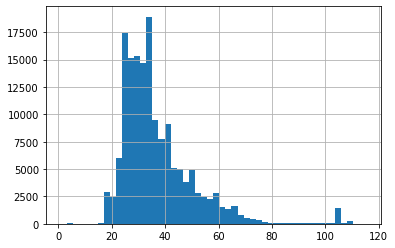

In [16]:
users[(users['age']<120)&(users['age']>0)]['age'].hist(bins=50)
plt.show()

- <font size=3>There are some values above 120, let's check them.

In [17]:
users[users['age']>=120]['age'].describe()

count     830.000000
mean     2002.620482
std        94.201344
min       132.000000
25%      2014.000000
50%      2014.000000
75%      2014.000000
max      2014.000000
Name: age, dtype: float64

- <font size=3>
    There are some values near 0, let's check them.

In [18]:
users[users['age']<18]['age'].describe()

count    188.000000
mean      12.718085
std        5.764569
min        1.000000
25%        5.000000
50%       16.000000
75%       17.000000
max       17.000000
Name: age, dtype: float64

- <font size=3>The young users seems to be under an acceptable range being the 50% of those users above 16 years old.

> <font size=3> Let's define that ages which are between 13 and 120 are acceptable.

In [19]:
## deal with outliers
users.loc[users['age']>120, 'age'] = np.nan
users.loc[users['age']<13, 'age'] = np.nan

#### 2.4 Numerical Variables Distribution

In [20]:
num_col = ['age','signup_flow']
cat_col = cat_cols = users.columns[~users.columns.isin(num_col)]
cat_col = cat_col.drop(['date_account_created','date_first_booking','timestamp_first_active'])

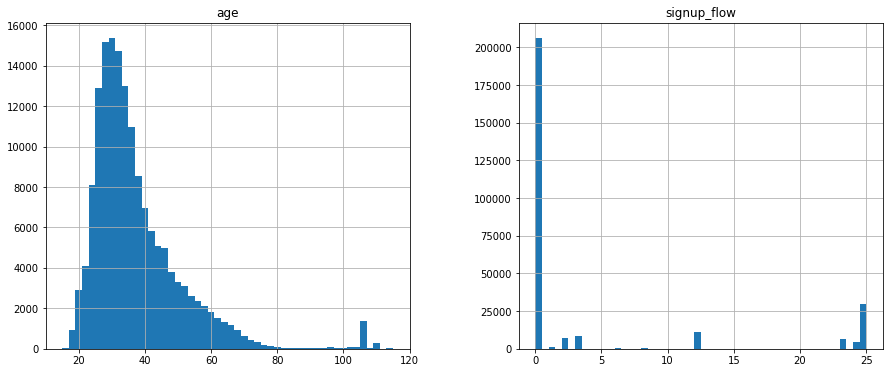

In [21]:
users[num_col].hist(figsize = (15,6), bins = 50, xlabelsize=10, ylabelsize=10)
plt.show()

#### 2.5 Categorical Variables Distribution

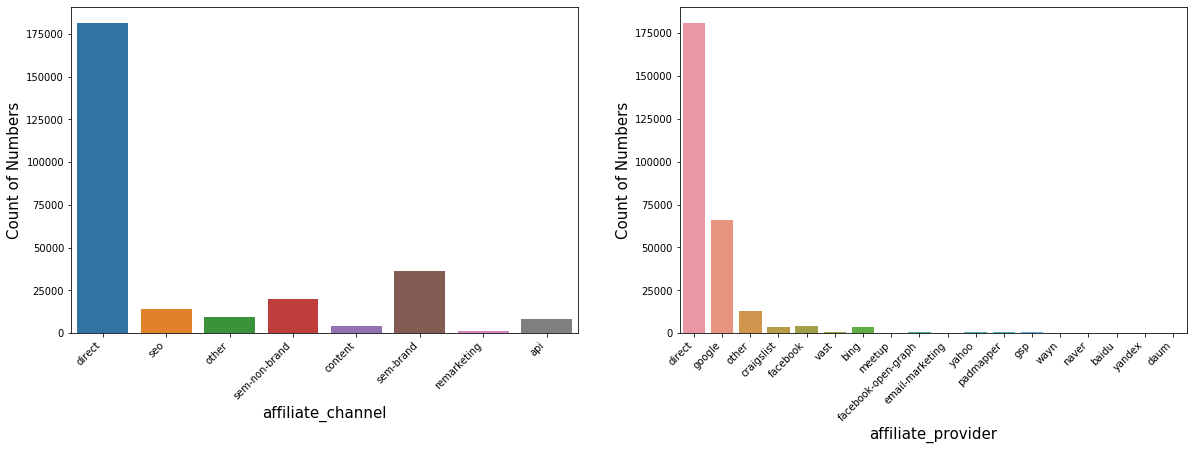

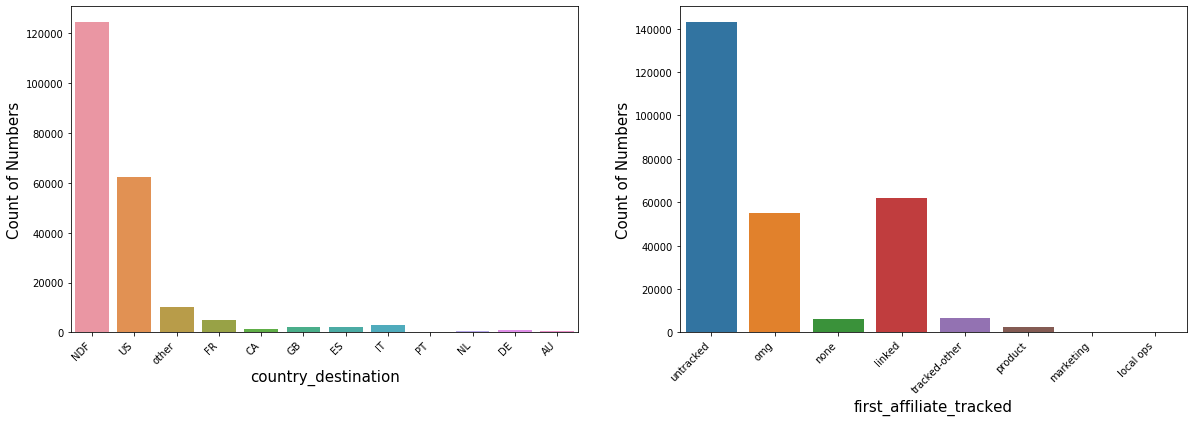

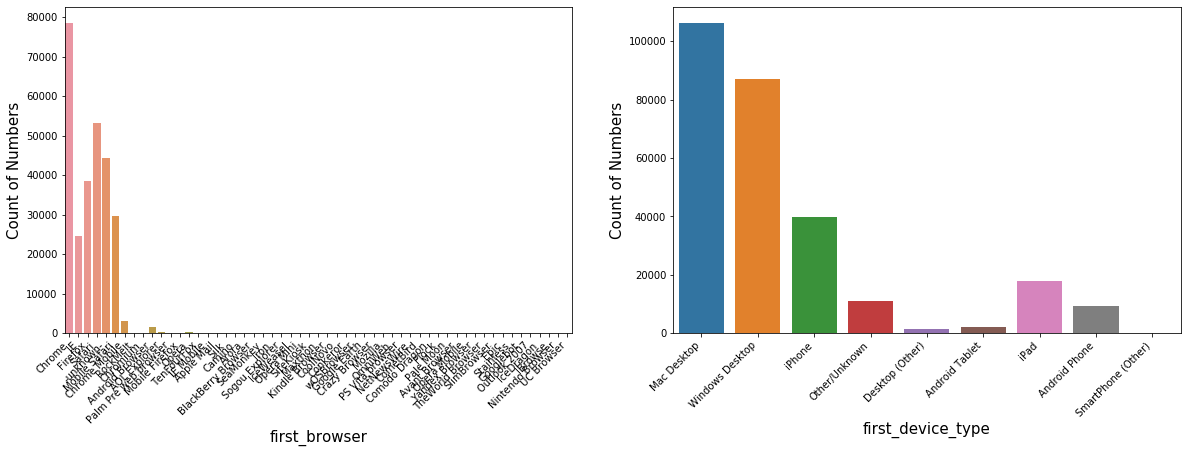

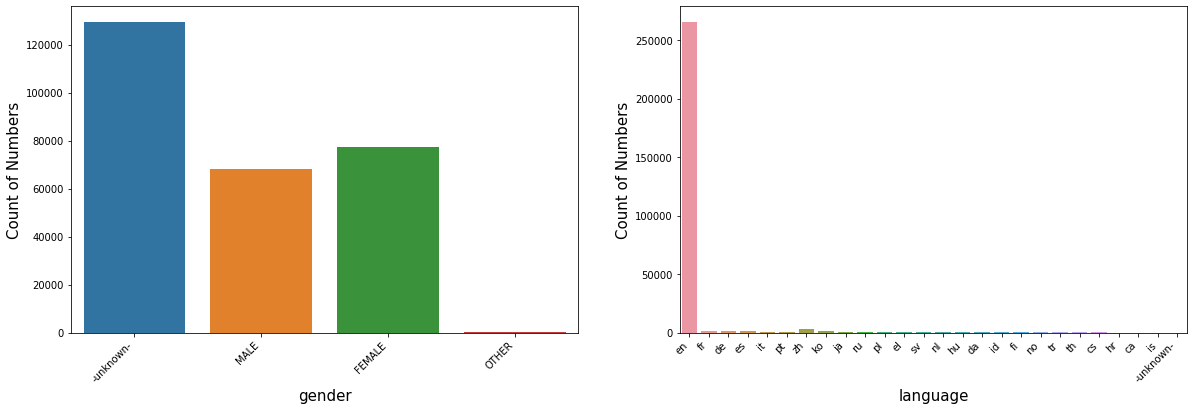

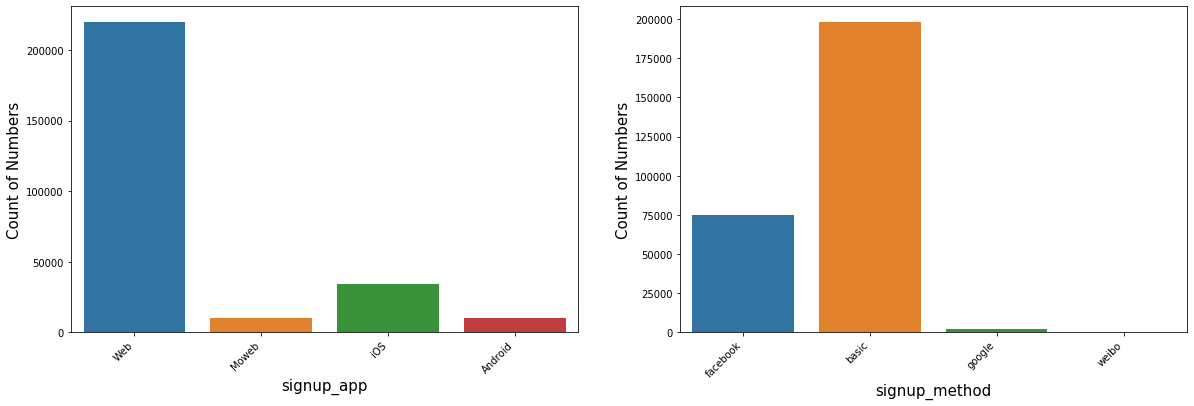

In [22]:
nrow = 5
ncol = 2

for i in range(nrow):
    fig, ax = plt.subplots(1, ncol, figsize=(20, 6))
    for j in range(ncol):
        chart = sns.countplot(x = users[cat_col[i * ncol + j]], ax= ax[j])
        chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right',fontsize = 10)
        chart.set_xlabel(xlabel = cat_col[i*ncol + j],fontsize = 15)
        chart.set_ylabel('Count of Numbers', fontsize = 15)

<font size=4> From the above charts, we can see:
    * affiliate_channel: The number of users come from direct channel is much more than others
    * affiliate_provider: The number of users come from direct provider is much more than others
    * country_destination: contains 'NDF' values, which means there wasn't a booking.
    * first_affiliate_tracked: contains 'untracted' values
    * first_browser: focus on Chrome
    * first_device_type: Users are mainly using Mac and Window desktop as their first device type
    * gender: has 'unknown' and 'other' values, and we can combine the two values into one
    * language: English is dormaint in Language variable
    * signup_app: The number of users using web to sign up is much more than other sign up apps

#### 2.6 deal with multiple category levels variables

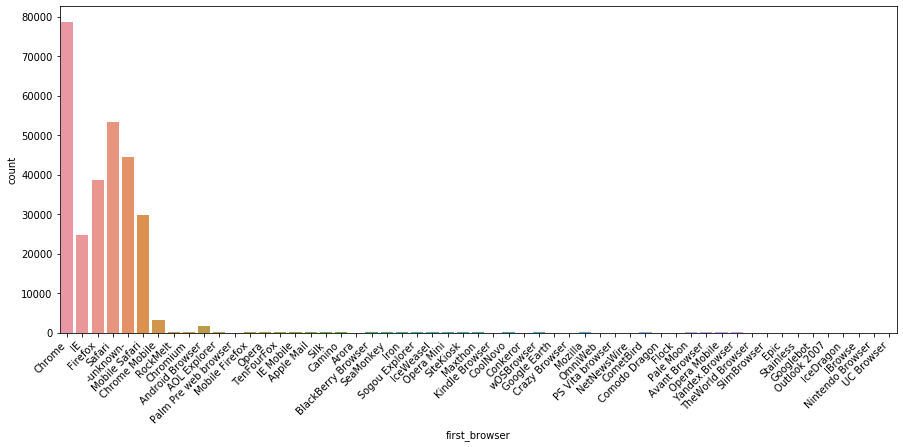

In [23]:
# first_browser variable
plt.figure(figsize=(15,6), edgecolor='white')
sns.countplot(x=users['first_browser'])
plt.xticks(rotation=45, horizontalalignment = 'right')
plt.show()

In [24]:
# combine first_browser numbers which are lower than 5000 as 'others'
## check values that are higher than 5000
browsers = users.groupby('first_browser').filter(lambda x: len(x) > 5000)['first_browser'].unique()
print(browsers)

## combine lower than 5000 as 'others'
users.loc[~users['first_browser'].isin(browsers), 'first_browser'] = 'others'

['Chrome' 'IE' 'Firefox' 'Safari' '-unknown-' 'Mobile Safari']


In [25]:
# age variable
users.age.unique()

array([ nan,  38.,  56.,  42.,  41.,  46.,  47.,  50.,  36.,  37.,  33.,
        31.,  29.,  30.,  40.,  26.,  32.,  35.,  59.,  49.,  44.,  34.,
        28.,  19.,  53.,  52.,  39.,  57.,  25.,  54.,  69.,  63.,  43.,
        55.,  65.,  58.,  61.,  18.,  27.,  45.,  60.,  48.,  51.,  64.,
        72.,  70.,  67.,  73., 104.,  66., 105.,  68.,  95.,  24.,  94.,
        75.,  79.,  62.,  16.,  23., 101.,  98.,  76.,  74.,  87.,  92.,
       115.,  71.,  84., 107.,  78.,  99., 110., 102.,  82.,  77.,  22.,
        89.,  21.,  15.,  20., 103.,  17.,  86.,  97.,  81.,  90.,  88.,
        80., 100.,  91., 106.,  83.,  85., 108., 113., 109.,  93.,  96.,
       111., 112.])

In [26]:
# split age into age buckets
users['age_bucket'] = pd.cut(users['age'], bins=[-1,4,9,14,19,24,29,34,39,44,49,54,59,64,69,74,79,84,89,94,99,120],
                             labels = ['0-4','5-9','10-14','15-19','20-24','25-29','30-34',
                                       '35-39','40-44','45-49','50-54','55-59','60-64','65-69',
                                       '70-74','75-79','80-84','85-89','90-94','95-99','100+'])

In [27]:
# fill nan values
users.age.fillna('NA', inplace=True)

# change category data type to object data type
users['age_bucket'] = users['age_bucket'].astype(str)

#### 2.7 see users behaviors over time

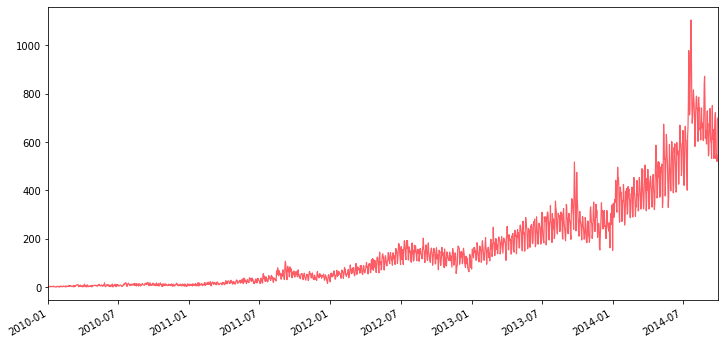

In [28]:
# the number of accounts created by time
plt.figure(figsize=(12,6))
users.date_account_created.value_counts().plot(kind='line', linewidth=1.2, color='#FD5C64')
plt.show()

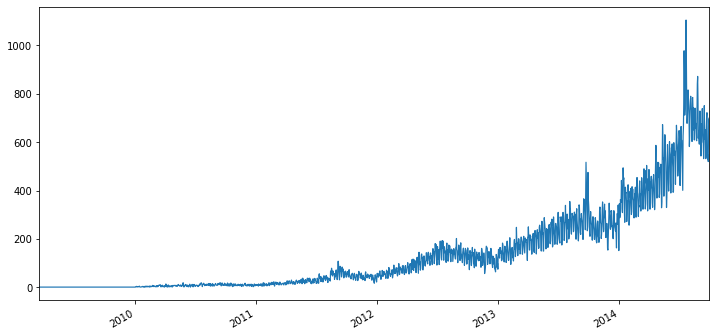

In [29]:
users['date_first_active'] = pd.to_datetime((users.timestamp_first_active // 1000000), format='%Y%m%d')

plt.figure(figsize=(12,6))
users.date_first_active.value_counts().plot(kind='line', linewidth=1.2)
plt.show()

- <font size=3>
    from the above charts, we can see that how fast Airbnb has grown over the last 3 years, and the pattern is almost the same as the date_first_active, which both have a small peak here.

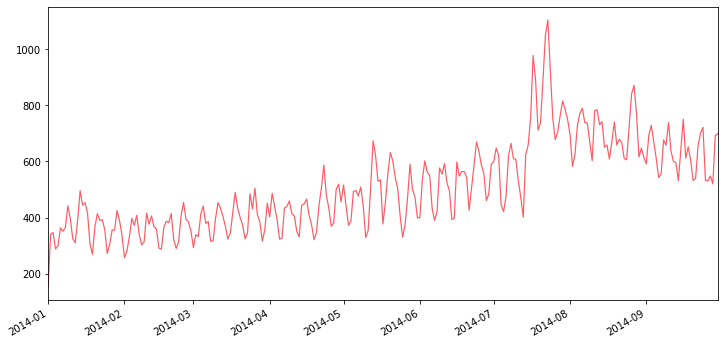

In [30]:
## dig into the peak after year 2014
plt.figure(figsize=(12,6))

users[users['date_account_created']>'2013-12-31']['date_account_created'].value_counts().plot(kind='line', 
                                                                                              linewidth=1.2, 
                                                                                              color='#FD5C64')
plt.show()

## 3. Feature Engineering

### 3.1 deal with date variables

#### date_account_created （dac）

In [31]:
## date_account_created variable
# created year, month, day, weekday, quarter features
users['dac_year'] = users['date_account_created'].dt.year
users['dac_month'] = users['date_account_created'].dt.month
users['dac_day'] = users['date_account_created'].dt.day
users['dac_weekday'] = users['date_account_created'].dt.weekday
users['dac_season'] = users['date_account_created'].dt.quarter

#### timestamp_first_active (tfa)

$s = datetime.datetime(int('2009'),int('03'),int('19'),int('04'),int('32'),int('55'))$

In [32]:
## timestamp_first_active variable
users.timestamp_first_active = users.timestamp_first_active.astype(str).apply(lambda x: 
                                                                              datetime.datetime(int(x[:4]),
                                                                                                int(x[4:6]), 
                                                                                                int(x[6:8]),
                                                                                                int(x[8:10]),
                                                                                                int(x[10:12]),
                                                                                                int(x[12:])))

In [33]:
## create year, month, day, quarter, weekday features
users['tfa_year'] = users['timestamp_first_active'].dt.year
users['tfa_month'] = users['timestamp_first_active'].dt.month
users['tfa_day'] = users['timestamp_first_active'].dt.day
users['tfa_weekday'] = users['timestamp_first_active'].dt.weekday
users['tfa_season'] = users['timestamp_first_active'].dt.quarter

#### Time span between dac and tfa can also be used as a feature

In [34]:
## create difference between date_account_created and timestamp_first_active
users['diff'] = (users['timestamp_first_active'] - users['date_account_created']).dt.seconds

In [35]:
## date_first_booking variable
users['date_first_booking'] = pd.to_datetime(users['date_first_booking'])

### 3.2 label encoding and one hot encoding

#### label encoder

In [36]:
from sklearn import preprocessing

In [37]:
feature_OHE = ['gender', 
               'signup_method', 
               'signup_flow', 
               'language', 
               'affiliate_channel', 
               'affiliate_provider', 
               'first_affiliate_tracked', 
               'signup_app', 
               'first_device_type', 
               'first_browser',
               'age_bucket']

In [38]:
## check how many levels for each category variable
print('{0:25s} {1}'.format('Variables','Levels'))
print('-' * 30)
for i in feature_OHE:
    values = users[i].nunique()
    print('{0:25s} {1}'.format(i, values))

Variables                 Levels
------------------------------
gender                    4
signup_method             4
signup_flow               18
language                  26
affiliate_channel         8
affiliate_provider        18
first_affiliate_tracked   8
signup_app                4
first_device_type         9
first_browser             7
age_bucket                19


In [40]:
## Label Encoder
LE = preprocessing.LabelEncoder()

LE_map=dict()
for i in feature_OHE:
    users[i] = LE.fit_transform(users[i])
    LE_map[i]=dict(zip(LE.classes_, LE.transform(LE.classes_)))

#### one-hot encoding

In [41]:
## one hot encoding
OHE = preprocessing.OneHotEncoder(sparse=False)
df_sparse = OHE.fit_transform(users[feature_OHE])

In [42]:
# get sparse dataset column names
OHE_vars = [var[:-3] + '_' + str(level).replace(' ','_') for var in feature_OHE for level in LE_map[var]]

df_sparse = pd.DataFrame(df_sparse, columns = OHE_vars)

# concat two tables
data = pd.concat((users, df_sparse), axis=1)

In [43]:
df = data.drop(['age','date_first_booking','date_first_active','timestamp_first_active'], axis=1)
df = df.drop(feature_OHE, axis=1)

---

## 4. Machine Learning

In [44]:
# split dataset into train dataset and test dataset on date_account_created
## date thredhold: 2014-06-30
train_df = df[df['date_account_created'] <= '2014-06-30']
test_df = df[df['date_account_created'] > '2014-06-30']

train_df = train_df.drop('date_account_created',axis=1)
test_df = test_df.drop(['date_account_created','country_destination'], axis=1)

### 4.1 Random Forest Model

In [45]:
X = train_df.drop('country_destination', axis = 1)
y = train_df['country_destination']

In [46]:
# label encoder the target variable - country_destination
labels_le = preprocessing.LabelEncoder()
ytrain = labels_le.fit_transform(y.values)
label_map = dict(zip(labels_le.classes_, labels_le.transform(labels_le.classes_)))

In [47]:
# split train dataset into train and validation datasets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, ytrain, test_size=0.2, random_state=123)

In [48]:
# create random forest model
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=50, max_depth=9)
rfc.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=50,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## 5. Model Evaluation
#### - NDCG (Normalized discounted cumulative gain)

<font size =4>DCG$_k$ = $\sum \limits _{i=1} ^{k}$ $2^{rel_i} -1 \over log_2(i+1)$
    
    
nDCG$_k$ = $DCG_k \over IDCG_k$
    

In [49]:
# define NDCG function
def dcg_score(y_true, y_score, k=5):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])
    
    gain = 2 ** y_true -1
    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

def ndcg_score(ground_truth, predictions, k=5):
    lb = preprocessing.LabelBinarizer()
    lb.fit(range(len(predictions) + 1))
    T = lb.transform(ground_truth)
    
    scores = []
    
    # interate over each y_true and compute the DCG score
    for y_true, y_score in zip(T, predictions):
        actual = dcg_score(y_true, y_score, k)
        best = dcg_score(y_true, y_true, k)
        score = float(actual) / float(best)
        scores.append(score)
        
    return np.mean(scores)

In [50]:
prediction = rfc.predict_proba(X_test)

In [51]:
train_ndcg_score = ndcg_score(y_test[:1000],prediction[:1000], k =5)
train_ndcg_score

0.8184846680120385

## 6. Prediction Result

In [52]:
# train the whole train dataset, and predict the test dataset
rfc.fit(X, ytrain)
predict = rfc.predict_proba(test_df)

In [53]:
id_test = test['id']

# Taking the 5 classes with highest probabilities
ids = []  #list of ids
cts = []  #list of countries
for i in range(len(id_test)):
    idx = id_test[i]
    ids += [idx] * 5
    cts += labels_le.inverse_transform(np.argsort(predict[i])[::-1])[:5].tolist()

In [54]:
# generate submission
submission = pd.DataFrame(np.column_stack((ids, cts)), columns = ['id','country_destination'])
submission.to_csv('submission.csv', index=False)